Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0132 - val_loss: 1.3423e-04
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0024 - val_loss: 3.0785e-04
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0020 - val_loss: 6.1045e-05
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0015 - val_loss: 1.1677e-04
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0014 - val_loss: 8.6739e-05
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0013 - val_loss: 2.1273e-04
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0015 - val_loss: 6.1566e-05
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0011 - val_loss: 6.1561e-05
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0015 - val_loss: 1.2738e-04
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 9.0532e-04 - val_loss: 7.4202e-04
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0012 - val_loss: 8.331

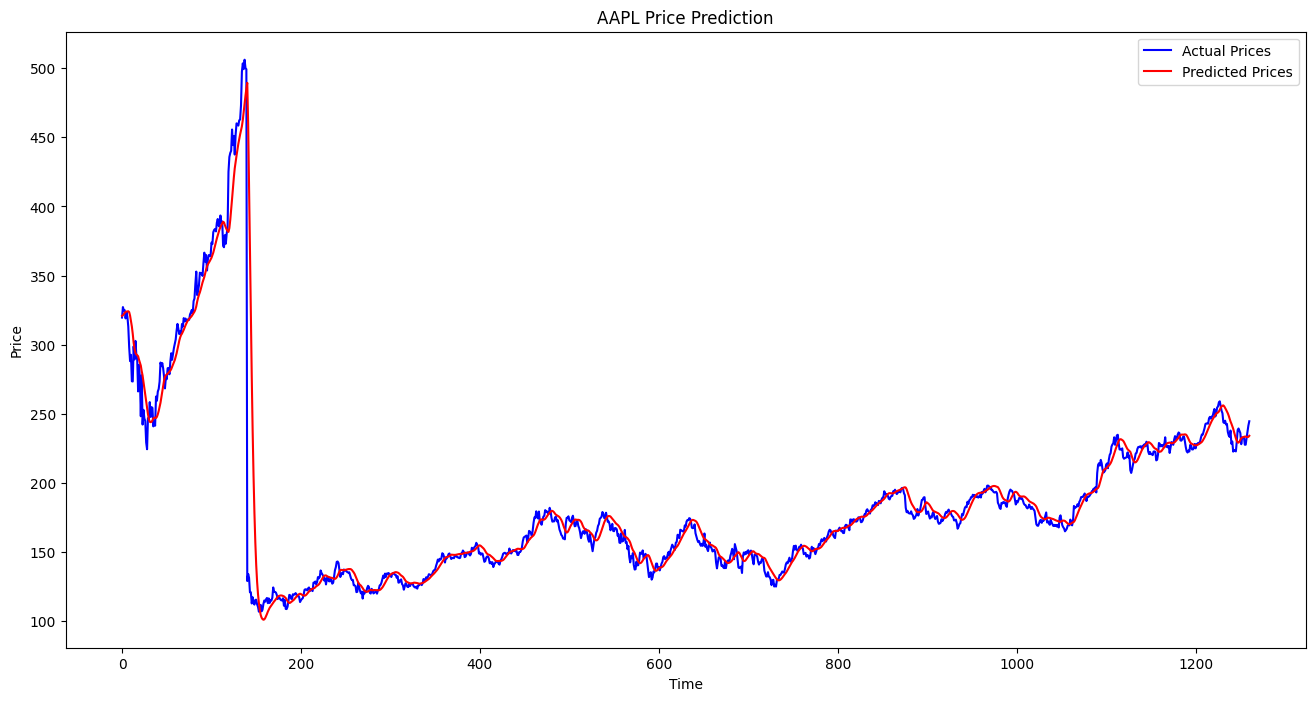

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Current price: $244.60
Predicted next price: $235.48
Trading decision: SELL
Model saved as AAPL_lstm_model.h5


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def prepare_data(df, target_symbol, sequence_length=60):
    """
    Prepare data for LSTM model
    
    Parameters:
    df (pandas.DataFrame): Dataframe containing stock data
    target_symbol (str): Symbol to predict
    sequence_length (int): Number of previous days to use for prediction
    
    Returns:
    tuple: (X_train, X_test, y_train, y_test, scaler)
    """

    target_df = df[df['symbol'] == target_symbol].sort_values('date')
    

    features = ['open', 'high', 'low', 'close', 'volume']
    data = target_df[features].values
    

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    # Prepare sequences
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i+sequence_length])

        y.append(scaled_data[i+sequence_length, 3])  # 3 is the index for 'close'
    
    X, y = np.array(X), np.array(y)
    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    return X_train, X_test, y_train, y_test, scaler


def create_lstm_model(input_shape):
    """
    Create an LSTM model for stock price prediction
    
    Parameters:
    input_shape (tuple): Shape of input data
    
    Returns:
    tensorflow.keras.models.Sequential: LSTM model
    """
    model = Sequential()
    

    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    

    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    

    model.add(Dense(units=25))
    model.add(Dense(units=1))  # Output layer
    

    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

def train_model(X_train, y_train, epochs=50, batch_size=32):
    """
    Train the LSTM model
    
    Parameters:
    X_train (numpy.array): Training features
    y_train (numpy.array): Training target
    epochs (int): Number of training epochs
    batch_size (int): Batch size for training
    
    Returns:
    tuple: (model, history)
    """
    model = create_lstm_model(X_train.shape[1:])
    

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )
    
    return model, history

def evaluate_model(model, X_test, y_test, scaler, features_shape):
    """
    Evaluate the model on test data
    
    Parameters:
    model (tensorflow.keras.models.Sequential): Trained model
    X_test (numpy.array): Test features
    y_test (numpy.array): Test target
    scaler (MinMaxScaler): Scaler used for normalization
    features_shape (int): Number of features
    
    Returns:
    tuple: (predictions, actual)
    """

    predictions = model.predict(X_test)
    

    dummy = np.zeros((len(predictions), features_shape))
    dummy[:, 3] = predictions.flatten()  # 3 is the index for 'close'
    predictions_transformed = scaler.inverse_transform(dummy)[:, 3]

    dummy = np.zeros((len(y_test), features_shape))
    dummy[:, 3] = y_test
    actual_transformed = scaler.inverse_transform(dummy)[:, 3]

    mse = np.mean((predictions_transformed - actual_transformed) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions_transformed - actual_transformed))
    
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    

    actual_direction = np.diff(actual_transformed, prepend=actual_transformed[0])
    predicted_direction = np.diff(predictions_transformed, prepend=predictions_transformed[0])
    

    actual_direction = actual_direction[1:]
    predicted_direction = predicted_direction[1:]
    

    correct_direction = (np.sign(actual_direction) == np.sign(predicted_direction)).sum()
    directional_accuracy = correct_direction / len(actual_direction) * 100
    
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")

    threshold = 0.01  # 1% change
    

    actual_returns = actual_direction / actual_transformed[:-1]
    predicted_returns = predicted_direction / predictions_transformed[:-1]
    

    buy_signals = predicted_returns > threshold
    if buy_signals.sum() > 0:
        correct_buys = (actual_returns[buy_signals] > 0).sum()
        buy_accuracy = correct_buys / buy_signals.sum() * 100
        print(f"Buy Signal Accuracy: {buy_accuracy:.2f}% ({correct_buys}/{buy_signals.sum()})")
    else:
        print("No buy signals generated")
    

    sell_signals = predicted_returns < -threshold
    if sell_signals.sum() > 0:
        correct_sells = (actual_returns[sell_signals] < 0).sum()
        sell_accuracy = correct_sells / sell_signals.sum() * 100
        print(f"Sell Signal Accuracy: {sell_accuracy:.2f}% ({correct_sells}/{sell_signals.sum()})")
    else:
        print("No sell signals generated")
    

    trading_signals = np.logical_or(buy_signals, sell_signals)
    if trading_signals.sum() > 0:
        correct_trades = (actual_returns[buy_signals] > 0).sum() + (actual_returns[sell_signals] < 0).sum()
        trading_accuracy = correct_trades / trading_signals.sum() * 100
        print(f"Overall Trading Accuracy: {trading_accuracy:.2f}% ({correct_trades}/{trading_signals.sum()})")
    else:
        print("No trading signals generated")
    
    return predictions_transformed, actual_transformed

def plot_results(actual, predictions, target_symbol):
    """
    Plot actual vs predicted prices
    
    Parameters:
    actual (numpy.array): Actual prices
    predictions (numpy.array): Predicted prices
    target_symbol (str): Stock symbol
    """
    plt.figure(figsize=(16, 8))
    plt.plot(actual, color='blue', label='Actual Prices')
    plt.plot(predictions, color='red', label='Predicted Prices')
    plt.title(f'{target_symbol} Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def make_trading_decision(model, latest_data, scaler, threshold=0.01):
    """
    Make a trading decision based on the model's prediction
    
    Parameters:
    model (tensorflow.keras.models.Sequential): Trained model
    latest_data (numpy.array): Latest sequence of data
    scaler (MinMaxScaler): Scaler used for normalization
    threshold (float): Threshold for deciding to buy/sell
    
    Returns:
    str: Trading decision ('buy', 'sell', or 'hold')
    float: Predicted next price
    float: Current price
    """

    latest_sequence = latest_data[-1:].reshape(1, latest_data.shape[1], latest_data.shape[2])
    

    next_price_scaled = model.predict(latest_sequence)[0, 0]
    

    current_price_scaled = latest_sequence[0, -1, 3]  # 3 is the index for 'close'
    

    dummy = np.zeros((1, latest_data.shape[2]))
    
    dummy[0, 3] = next_price_scaled
    next_price = scaler.inverse_transform(dummy)[0, 3]
    
    dummy[0, 3] = current_price_scaled
    current_price = scaler.inverse_transform(dummy)[0, 3]
    

    expected_return = (next_price - current_price) / current_price
    

    if expected_return > threshold:
        decision = 'buy'
    elif expected_return < -threshold:
        decision = 'sell'
    else:
        decision = 'hold'
    
    return decision, next_price, current_price

def main():

    df = pd.read_csv('/Users/devshah/Documents/WorkSpace/University/year 3/CSC392/Trading_Simulator/data/stock_data.csv', index_col=0)
    df['date'] = pd.to_datetime(df['date'])
    

    target_symbol = 'AAPL'  # Change to your desired stock
    

    X_train, X_test, y_train, y_test, scaler = prepare_data(df, target_symbol)
    

    model, history = train_model(X_train, y_train, epochs=100)
    

    predictions, actual = evaluate_model(model, X_test, y_test, scaler, X_train.shape[2])
    

    plot_results(actual, predictions, target_symbol)
    

    target_df = df[df['symbol'] == target_symbol].sort_values('date')
    features = ['open', 'high', 'low', 'close', 'volume']
    latest_data = target_df[features].values[-60:] 
    latest_data = scaler.transform(latest_data).reshape(1, 60, 5)
    

    decision, next_price, current_price = make_trading_decision(model, latest_data, scaler)
    
    print(f"Current price: ${current_price:.2f}")
    print(f"Predicted next price: ${next_price:.2f}")
    print(f"Trading decision: {decision.upper()}")
    

    model.save(f'{target_symbol}_lstm_model.h5')
    print(f"Model saved as {target_symbol}_lstm_model.h5")

if __name__ == "__main__":
    main()

Fetching fresh stock data...
Fetching data for AAPL...
Successfully fetched 6377 days of data for AAPL
Fetching data for MSFT...
Successfully fetched 6377 days of data for MSFT
Fetching data for GOOGL...
Successfully fetched 5172 days of data for GOOGL
Fetching data for AMZN...
Successfully fetched 6377 days of data for AMZN


Dataset saved to stock_data.csv
               open    high       low   close    volume       date symbol
2025-03-10  235.540  236.16  224.2200  227.48  71451281 2025-03-10   AAPL
2025-03-07  235.105  241.37  234.7600  239.07  46273565 2025-03-07   AAPL
2025-03-06  234.435  237.86  233.1581  235.33  45170419 2025-03-06   AAPL
2025-03-05  235.420  236.55  229.2300  235.74  47227643 2025-03-05   AAPL
2025-03-04  237.705  240.07  234.6800  235.93  53798062 2025-03-04   AAPL
...             ...     ...       ...     ...       ...        ...    ...
1999-11-05   64.750   65.50   62.2500   64.94  11091400 1999-11-05   AMZN
1999-11-04   67.190   67.19   61.0000   63.06  16759200 1999-11-04   AMZN
1999-11-03   68.190   68.50   65.0000   65.81  10772100 1999-11-03   AMZN
1999-11-02   69.750   70.00   65.0600   66.44  13243200 1999-11-02   AMZN
1999-11-01   68.060   71.88   66.3100   69.13  12824100 1999-11-01   AMZN

[24303 rows x 7 columns]
Loading model from AAPL_lstm_model.h5
Using 6377 days 

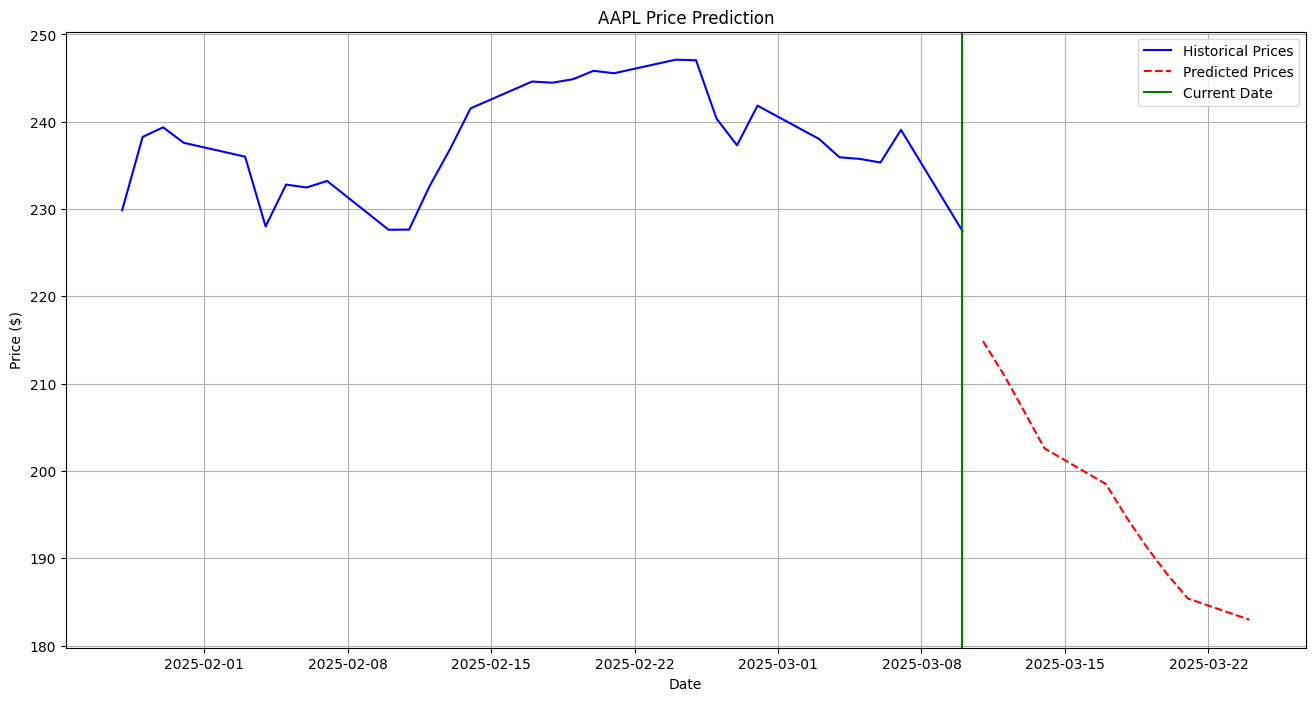

Predictions saved to AAPL_predictions.csv


In [9]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import time
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

def get_alpha_vantage_data(symbol, api_key, function='TIME_SERIES_DAILY', output_size='full'):
    """
    Fetch stock data from Alpha Vantage API
    
    Parameters:
    symbol (str): Stock symbol (e.g., 'AAPL' for Apple)
    api_key (str): Your Alpha Vantage API key
    function (str): Type of time series data to fetch
    output_size (str): 'compact' for latest 100 datapoints, 'full' for all available data
    
    Returns:
    pandas.DataFrame: Historical stock data
    """
    base_url = 'https://www.alphavantage.co/query'
    params = {
        'function': function,
        'symbol': symbol,
        'apikey': api_key,
        'outputsize': output_size
    }
    
    response = requests.get(base_url, params=params)
    data = response.json()
    
    # Check for error messages
    if "Error Message" in data:
        raise ValueError(f"API Error: {data['Error Message']}")
    
    # Extract time series data
    if function == 'TIME_SERIES_DAILY':
        time_series_key = 'Time Series (Daily)'
    elif function == 'TIME_SERIES_WEEKLY':
        time_series_key = 'Weekly Time Series'
    else:
        time_series_key = 'Time Series (Daily)'  # Default
    
    # Convert to DataFrame
    df = pd.DataFrame(data[time_series_key]).T
    
    # Convert string values to float
    for col in df.columns:
        df[col] = pd.to_numeric(df[col])
    
    # Rename columns
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    
    # Add date as a column
    df.index = pd.to_datetime(df.index)
    df['date'] = df.index
    
    return df

def create_dataset(symbols, api_key, save_path='stock_data.csv'):
    """
    Create a dataset for multiple stock symbols
    
    Parameters:
    symbols (list): List of stock symbols
    api_key (str): Alpha Vantage API key
    save_path (str): Path to save the CSV file
    
    Returns:
    pandas.DataFrame: Combined dataset of all symbols
    """
    all_data = []
    
    for symbol in symbols:
        print(f"Fetching data for {symbol}...")
        try:
            df = get_alpha_vantage_data(symbol, api_key)
            df['symbol'] = symbol
            all_data.append(df)
            print(f"Successfully fetched {len(df)} days of data for {symbol}")
            time.sleep(12)  # Alpha Vantage has a limit of 5 API calls per minute for free tier
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
    
    # Combine all data
    if all_data:
        combined_df = pd.concat(all_data)
        combined_df.to_csv(save_path)
        print(f"Dataset saved to {save_path}")
        return combined_df
    else:
        print("No data was fetched")
        return None

def prepare_latest_data(target_df, scaler=None, sequence_length=60):
    """
    Prepare the latest data sequence for prediction
    
    Parameters:
    target_df (pandas.DataFrame): Dataframe containing target stock data
    scaler (MinMaxScaler, optional): Pre-fitted scaler. If None, a new scaler will be fitted.
    sequence_length (int): Number of previous days to use for prediction
    
    Returns:
    tuple: (latest_sequence, scaler)
    """
    features = ['open', 'high', 'low', 'close', 'volume']
    data = target_df[features].values
    
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data)
    else:
        scaled_data = scaler.transform(data)
    
    # Get the latest sequence
    latest_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, len(features))
    
    return latest_sequence, scaler

def predict_future_prices(model, latest_sequence, scaler, days_ahead=10, features_count=5):
    """
    Predict future prices for multiple days ahead
    
    Parameters:
    model (tensorflow.keras.Model): Trained LSTM model
    latest_sequence (numpy.array): Latest sequence of data
    scaler (MinMaxScaler): Scaler used for normalization
    days_ahead (int): Number of days to predict ahead
    features_count (int): Number of features in the data
    
    Returns:
    list: Predicted prices for specified days ahead
    """
    predictions = []
    current_sequence = latest_sequence.copy()
    
    for _ in range(days_ahead):
        # Predict the next day
        next_pred = model.predict(current_sequence, verbose=0)[0, 0]
        
        # Store the prediction
        dummy = np.zeros((1, features_count))
        dummy[0, 3] = next_pred  # 3 is the index for 'close'
        next_price = scaler.inverse_transform(dummy)[0, 3]
        predictions.append(next_price)
        
        # Update the sequence for the next prediction
        new_pred = np.zeros((1, 1, features_count))
        new_pred[0, 0, :] = current_sequence[0, -1, :]  # Copy the last day's values
        new_pred[0, 0, 3] = next_pred  # Update only the close price
        
        # Remove the first day and add the new prediction
        current_sequence = np.append(current_sequence[:, 1:, :], new_pred, axis=1)
    
    return predictions

def make_multiple_trading_decisions(model, latest_sequence, scaler, days_ahead=10, threshold=0.01):
    """
    Make trading decisions for multiple days ahead
    
    Parameters:
    model (tensorflow.keras.Model): Trained LSTM model
    latest_sequence (numpy.array): Latest sequence of data
    scaler (MinMaxScaler): Scaler used for normalization
    days_ahead (int): Number of days to predict ahead
    threshold (float): Threshold for deciding to buy/sell
    
    Returns:
    list: List of dictionaries containing date offset, predicted price, and trading decision
    """
    predictions = predict_future_prices(model, latest_sequence, scaler, days_ahead)
    
    # Get the current price (last known price)
    dummy = np.zeros((1, latest_sequence.shape[2]))
    dummy[0, 3] = latest_sequence[0, -1, 3]  # 3 is the index for 'close'
    current_price = scaler.inverse_transform(dummy)[0, 3]
    
    results = []
    prev_price = current_price
    
    for i, next_price in enumerate(predictions):
        expected_return = (next_price - prev_price) / prev_price
        
        if expected_return > threshold:
            decision = 'BUY'
        elif expected_return < -threshold:
            decision = 'SELL'
        else:
            decision = 'HOLD'
        
        results.append({
            'day': i + 1,
            'predicted_price': next_price,
            'expected_return': expected_return * 100,  # Convert to percentage
            'decision': decision
        })
        
        prev_price = next_price
    
    return results

def plot_predictions(historical_prices, predicted_prices, symbol, last_date):
    """
    Plot historical and predicted prices
    
    Parameters:
    historical_prices (numpy.array): Historical prices
    predicted_prices (list): Predicted future prices
    symbol (str): Stock symbol
    last_date (datetime): Last date in the historical data
    """
    # Create date range for predictions
    future_dates = [last_date + BDay(i+1) for i in range(len(predicted_prices))]
    
    # Historical dates (last 30 days)
    hist_dates = pd.date_range(end=last_date, periods=min(30, len(historical_prices)), freq='B')
    hist_subset = historical_prices[-len(hist_dates):]
    
    plt.figure(figsize=(16, 8))
    plt.plot(hist_dates, hist_subset, color='blue', label='Historical Prices')
    plt.plot(future_dates, predicted_prices, color='red', label='Predicted Prices', linestyle='--')
    plt.axvline(x=last_date, color='green', linestyle='-', label='Current Date')
    plt.title(f'{symbol} Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{symbol}_prediction.png')
    plt.show()

def main():
    # Replace with your actual API key
    API_KEY = "TKZMZK2F3VMKJ58C" # Replace with your Alpha Vantage API key
    
    # Define symbols to fetch data for
    symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']  # Add more symbols as needed
    
    # Path for saving the dataset
    data_path = 'stock_data.csv'
    
    # Fetch fresh data and create dataset
    print("Fetching fresh stock data...")
    dataset = create_dataset(symbols, API_KEY, data_path)
    
    # if dataset is None:
    #     print("Failed to fetch data. Check your API key or internet connection.")
    #     return
    print(dataset)
    # Choose a symbol to make predictions for
    symbol = 'AAPL'  # Change to your desired stock
    
    # Path to saved model
    model_path = f'{symbol}_lstm_model.h5'
    
    # Check if model exists
    if not os.path.exists(model_path):
        print(f"Model file {model_path} not found. Please train the model first.")
        return
    
    # Load the model
    print(f"Loading model from {model_path}")
    model = load_model(model_path)
    
    # Filter data for the selected symbol
    target_df = dataset[dataset['symbol'] == symbol].sort_values('date')
    
    if len(target_df) < 60:  # Minimum required for sequence_length
        print(f"Not enough data for {symbol}. Need at least 60 days of data.")
        return
    
    print(f"Using {len(target_df)} days of data for {symbol}")
    
    # Prepare scaler and latest data
    features = ['open', 'high', 'low', 'close', 'volume']
    data = target_df[features].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(data)
    
    latest_sequence, _ = prepare_latest_data(target_df, scaler)
    
    # Get the most recent date in the data
    last_date = target_df['date'].iloc[-1]
    
    # Make prediction for next day
    dummy = np.zeros((1, len(features)))
    dummy[0, 3] = latest_sequence[0, -1, 3]  # Current scaled close price
    current_price = scaler.inverse_transform(dummy)[0, 3]
    
    next_day_pred = model.predict(latest_sequence, verbose=0)[0, 0]
    dummy[0, 3] = next_day_pred
    next_price = scaler.inverse_transform(dummy)[0, 3]
    
    expected_return = (next_price - current_price) / current_price * 100
    
    print(f"\nCurrent date: {last_date.strftime('%Y-%m-%d')}")
    print(f"Current price: ${current_price:.2f}")
    print(f"Predicted next day price: ${next_price:.2f}")
    print(f"Expected return: {expected_return:.2f}%")
    
    if expected_return > 1:
        decision = 'BUY'
    elif expected_return < -1:
        decision = 'SELL'
    else:
        decision = 'HOLD'
    
    print(f"Trading decision: {decision}")
    
    # Predict for the next 10 days
    days_to_predict = 10
    print(f"\nPredicting prices for the next {days_to_predict} trading days:")
    future_predictions = make_multiple_trading_decisions(model, latest_sequence, scaler, days_to_predict)
    
    # Display the predictions in a table
    print("\nDay | Predicted Price | Expected Return | Decision")
    print("-" * 50)
    for pred in future_predictions:
        print(f"{pred['day']:3d} | ${pred['predicted_price']:.2f} | {pred['expected_return']:+.2f}% | {pred['decision']}")
    
    # Plot the historical and predicted prices
    historical_prices = target_df['close'].values
    predicted_prices = [pred['predicted_price'] for pred in future_predictions]
    plot_predictions(historical_prices, predicted_prices, symbol, last_date)
    
    # Save predictions to CSV
    pred_df = pd.DataFrame(future_predictions)
    pred_df['date'] = [last_date + BDay(i) for i in pred_df['day']]
    pred_df.to_csv(f'{symbol}_predictions.csv', index=False)
    print(f"Predictions saved to {symbol}_predictions.csv")

if __name__ == "__main__":
    main()